# Create Zarr of 9 years of daily CSSP China data [1851-1859]

In [1]:
import iris
import os
import sys
import logging
import xarray as xr
import numpy as np

import crd_utils as crd
import umdates_utils as um

from datetime import datetime, timedelta

## Create a list of all the files we want to process

In [2]:
# daily data filenames
filepath = '/data/cssp-china/mini-dataset-24-01-19/20CR/daily'
files = sorted(os.listdir(filepath))
print(len(files))

5850


In [3]:
# generate all possible filenames for the time period
runid = 'apepd'
startd = datetime(1851, 1, 1)   # 00Z on Jan 01 1851
endd = datetime(1860, 1, 1)     # 00Z on Jan 01 1860
freq = 'pa'

decade_filenames = um.UMFileList(runid, startd, endd, freq)
print(len(decade_filenames))

3288


In [4]:
# find the overlap of actual filenames with all possible filenames in that decade
filenames = list(set(files).intersection(set(decade_filenames)))
filenames.sort()
print(len(filenames))

329


In [5]:
filepaths = [os.path.join(filepath, filename) for filename in filenames]
print(len(filepaths))

329


## Set all the Cube, Dataset and Zarr variables we need to process the cubes

In [6]:
%%time
cubelist = iris.load(filepaths[0:1])
cubelist[7]

CPU times: user 1.56 s, sys: 97.3 ms, total: 1.66 s
Wall time: 1.81 s


<iris 'Cube' of geopotential_height / (m) (time: 4; pressure: 14; grid_latitude: 219; grid_longitude: 286)>

In [7]:
print(cubelist)

0: m01s05i217 / (unknown)              (time: 4; grid_latitude: 219; grid_longitude: 286)
1: air_pressure_at_sea_level / (Pa)    (time: 4; grid_latitude: 219; grid_longitude: 286)
2: air_temperature / (K)               (time: 4; grid_latitude: 219; grid_longitude: 286)
3: air_temperature / (K)               (time: 4; grid_latitude: 219; grid_longitude: 286)
4: air_temperature / (K)               (time: 4; grid_latitude: 219; grid_longitude: 286)
5: air_temperature / (K)               (time: 4; pressure: 14; grid_latitude: 219; grid_longitude: 286)
6: cloud_area_fraction / (1)           (time: 4; grid_latitude: 219; grid_longitude: 286)
7: geopotential_height / (m)           (time: 4; pressure: 14; grid_latitude: 219; grid_longitude: 286)
8: precipitation_flux / (kg m-2 s-1)   (time: 4; grid_latitude: 219; grid_longitude: 286)
9: relative_humidity / (%)             (time: 4; grid_latitude: 219; grid_longitude: 286)
10: relative_humidity / (%)             (time: 4; grid_latitude: 219; gr

In [8]:
CUBENAMES = [cube.name() for cube in cubelist]
UNIQUE_COORDS = crd.unique_coords_list(cubelist)
COORD_NAME_MAPPING = crd.get_new_coord_names(UNIQUE_COORDS)

In [9]:
print([coord.name() for coord in UNIQUE_COORDS])

['time', 'grid_latitude', 'grid_longitude', 'forecast_reference_time', 'forecast_period', 'height', 'pressure', 'grid_latitude', 'grid_longitude', 'height']


In [10]:
COORD_NAME_MAPPING[1]

('grid_latitude_1', 'grid_longitude_1', 'height_1')

In [6]:
ZARR = '/data/cssp-china/zarr_daily_1851-1859'
CHUNKS = {'time': 200, 'pressure':1, 'grid_latitude': 219, 'grid_longitude': 286, 'grid_latitude_1': 218, 'grid_longitude_1': 286}

## Initialise logging

In [12]:
LOGFILE = '/data/cssp-china/zarr_append_log.log'
logging.basicConfig(filename=LOGFILE,
                    level=logging.DEBUG,
                    format='%(asctime)s %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S')

In [13]:
if not os.path.isfile(LOGFILE):
    os.mknod(LOGFILE)

if os.stat(LOGFILE).st_size == 0:
    logging.info('Initiate log')
    print(f'Log initiated at {LOGFILE}')

## Create a Zarr with 21 cubes, which definitely amounts to 200 time steps (~20 days)

In [14]:
%%time
cubelist0 = iris.load(filepaths[0:21])
cubelist0[7]

CPU times: user 1min 15s, sys: 5.65 s, total: 1min 20s
Wall time: 1min 41s


<iris 'Cube' of geopotential_height / (m) (time: 204; pressure: 14; grid_latitude: 219; grid_longitude: 286)>

In [15]:
%%time
crd.rename_cubes(cubelist0, CUBENAMES, COORD_NAME_MAPPING, dryrun=False)

m01s05i217 -> m01s05i217_max
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x forecast_period
air_pressure_at_sea_level
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x forecast_period
air_temperature -> air_temperature_at_2m_mean
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x height
  x forecast_period
air_temperature -> air_temperature_at_2m_max
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x height
  x forecast_period
air_temperature -> air_temperature_at_2m_min
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x height
  x forecast_period
air_temperature -> air_temperature_at_pressure_mean
  x time
  x pressure
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x forecast_period
cloud_area_fraction
  x time
  x grid_latitude
  x grid_longitude
  x forecast_reference_time
  x forecast_period
geopotential_height
  x time
  x 

In [16]:
%%time
dalist0 = crd.cubelist_to_dalist(cubelist0)
ds0 = xr.merge(dalist0)

CPU times: user 229 ms, sys: 8.37 ms, total: 237 ms
Wall time: 240 ms


In [17]:
ds0

<xarray.Dataset>
Dimensions:                                    (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, pressure: 14, time: 204)
Coordinates:
  * time                                       (time) datetime64[ns] 1851-01-01T12:00:00 ... 1851-07-23T12:00:00
  * grid_latitude                              (grid_latitude) float32 22.88 ... -25.08
  * grid_longitude                             (grid_longitude) float32 323.48 ... 386.18002
    forecast_reference_time                    datetime64[ns] 1849-12-01
    forecast_period                            (time) timedelta64[ns] 396 days 12:00:00 ... 599 days 12:00:00
    height                                     float64 1.5
  * pressure                                   (pressure) float32 10.0 ... 1000.0
  * grid_latitude_1                            (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude_1                           (grid_longitude_1) float32 323.59003 ... 386.29004
    height_1                                   float64 10.0
Data variables:
    m01s05i217_max                             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    air_pressure_at_sea_level                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_mean                 (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_max                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_min                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    air_temperature_at_pressure_mean           (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 219, 286), meta=np.ndarray>
    cloud_area_fraction                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    geopotential_height                        (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 219, 286), meta=np.ndarray>
    precipitation_flux                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_mean               (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_max                (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_min                (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    relative_humidity_at_pressure_mean         (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 219, 286), meta=np.ndarray>
    specific_humidity                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    surface_air_pressure                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    surface_downwelling_longwave_flux_in_air   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    surface_temperature_mean                   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    surface_temperature_max                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 219, 286), meta=np.ndarray>
    surface_temperature_min                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksiz

In [18]:
%%time
logging.info(f'Creating {ZARR}')
crd.ds_to_zarr(ds0, ZARR, chunks=CHUNKS)

Written dataset to /data/cssp-china/zarr_daily_1851-1859
CPU times: user 47.3 s, sys: 11 s, total: 58.4 s
Wall time: 1min 31s


In [19]:
dsz0 = xr.open_zarr(ZARR)
dsz0

<xarray.Dataset>
Dimensions:                                    (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, pressure: 14, time: 204)
Coordinates:
    forecast_period                            (time) timedelta64[ns] dask.array<chunksize=(204,), meta=np.ndarray>
    forecast_reference_time                    datetime64[ns] ...
  * grid_latitude                              (grid_latitude) float32 22.88 ... -25.08
  * grid_latitude_1                            (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude                             (grid_longitude) float32 323.48 ... 386.18002
  * grid_longitude_1                           (grid_longitude_1) float32 323.59003 ... 386.29004
    height                                     float64 ...
    height_1                                   float64 ...
  * pressure                                   (pressure) float32 10.0 ... 1000.0
  * time                                       (time) datetime64[ns] 1851-01-01T12:00:00 ... 1851-07-23T12:00:00
Data variables:
    air_pressure_at_sea_level                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_max                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_mean                 (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_min                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_pressure_mean           (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 219, 286), meta=np.ndarray>
    cloud_area_fraction                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    geopotential_height                        (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 219, 286), meta=np.ndarray>
    m01s05i217_max                             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    precipitation_flux                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_max                (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_mean               (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_min                (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_pressure_mean         (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 219, 286), meta=np.ndarray>
    specific_humidity                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_air_pressure                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_downwelling_longwave_flux_in_air   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_temperature_max                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_temperature_mean                   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_temperature_min                    (time, grid_latitude, grid_lo

In [20]:
# Size of Dataset in GB
dsz0.nbytes / 1e9

4.541737716

In [21]:
logging.info(f'  Successfull creation of {ZARR}')
logging.info(f'  Processed filenames 0:{filenames[0]} - 21:{filenames[21]}')
logging.info(f'  Chunking {CHUNKS}')

## Now loop through the remaining cubes and append to the Zarr we created

In [14]:
def logprint(message):
    logging.info(message)
    print(message)

In [48]:
%%time
# Loop through in bunches of 12 cubes, so as to not use to much memory at one time
start = 319
step = 12
stop = len(filepaths)
# stop = start+(2*step)

logprint(f'Appending data to {ZARR}')

for i in range(start, stop, step):
    fnames = filenames[i:i+step]
    logprint(f'  Processing filenames {i}:{fnames[1]} - {min([i+step, stop])}:{fnames[-1]}')
    try:
        cubelist = iris.load(filepaths[i:i+step])
        logprint(f'  | Loaded files successfully')
        
        crd.rename_cubes(cubelist, CUBENAMES, COORD_NAME_MAPPING, dryrun=False, verbose=False)
        logprint(f'  | Renamed files successfully')
        
        dalist = crd.cubelist_to_dalist(cubelist)
        ds = xr.merge(dalist)
        logprint(f'  | Created dataset successfully')
        
        crd.ds_to_zarr(ds, ZARR, chunks=CHUNKS)
        logprint(f'  | Appended to Zarr {ZARR} successfully')
        
    except Exception as e:
        logprint(f'  X ERROR: {e}')
        raise e

logprint(f'  Appending data complete')

Appending data to /data/cssp-china/zarr_daily_1851-1859
  Processing filenames 319:apepda.pa59aa0.pp - 329:apepda.pa59ct0.pp
  | Loaded files successfully
  | Renamed files successfully
  | Created dataset successfully
Appended dataset to /data/cssp-china/zarr_daily_1851-1859
  | Appended to Zarr /data/cssp-china/zarr_daily_1851-1859 successfully
  Appending data complete
CPU times: user 1min 10s, sys: 14 s, total: 1min 24s
Wall time: 2min 25s


In [7]:
dsz1 = xr.open_zarr(ZARR)
dsz1

<xarray.Dataset>
Dimensions:                                    (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, pressure: 14, time: 3244)
Coordinates:
    forecast_period                            (time) timedelta64[ns] dask.array<chunksize=(204,), meta=np.ndarray>
    forecast_reference_time                    datetime64[ns] ...
  * grid_latitude                              (grid_latitude) float32 22.88 ... -25.08
  * grid_latitude_1                            (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude                             (grid_longitude) float32 323.48 ... 386.18002
  * grid_longitude_1                           (grid_longitude_1) float32 323.59003 ... 386.29004
    height                                     float64 ...
    height_1                                   float64 ...
  * pressure                                   (pressure) float32 10.0 ... 1000.0
  * time                                       (time) datetime64[ns] 1851-01-01T12:00:00 ... 1859-12-28T12:00:00
Data variables:
    air_pressure_at_sea_level                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_max                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_mean                 (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_2m_min                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    air_temperature_at_pressure_mean           (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 219, 286), meta=np.ndarray>
    cloud_area_fraction                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    geopotential_height                        (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 219, 286), meta=np.ndarray>
    m01s05i217_max                             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    precipitation_flux                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_max                (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_mean               (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_2m_min                (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    relative_humidity_at_pressure_mean         (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 219, 286), meta=np.ndarray>
    specific_humidity                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_air_pressure                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_downwelling_longwave_flux_in_air   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_temperature_max                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_temperature_mean                   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    surface_temperature_min                    (time, grid_latitude, grid_l

In [8]:
cubez = dsz1.air_pressure_at_sea_level.to_iris()
cubez

<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 3244; grid_latitude: 219; grid_longitude: 286)>

In [9]:
deltas = cubez.coord('time').points[1:]-cubez.coord('time').points[0:-1]
deltas

array([24, 24, 24, ..., 24, 24, 24])

In [10]:
import matplotlib.pyplot as plt
def plot_td_hist(td, **kwargs):
    plt.hist(td, log=True, **kwargs)
    plt.gcf().set_size_inches(15, 5)
#     plt.xticks(np.arange(1, 31))
    plt.xlabel('Days')
    plt.ylabel('Number of timedeltas')
    plt.title(f'Timedeltas for daily data')
    plt.show()

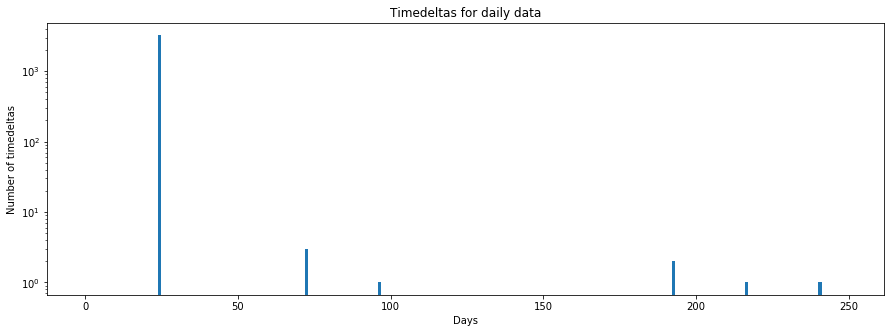

In [12]:
plot_td_hist(deltas, bins=np.arange(0, 250, 1))